In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.2.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.3.4
numpy 1.19.5
pandas 1.1.5
sklearn 0.24.2
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [1]:
!pwd

/home/pengjiaren/file1/chapter_2


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
# x = (x - u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)


In [4]:
# tf.keras.models.Sequential()

"""
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
"""

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3], 
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3

# reason for sparse: y->index. y->one_hot->[] 
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(0.001),
              metrics = ["accuracy"])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Tensorboard, earlystopping, ModelCheckpoint
# 必须先创建文件夹
logdir = './callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
    
#模型保存路径
# fashion_mnist_model.h5这个文件vim打不开
output_model_file = os.path.join(logdir,
                                 "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),#画图使用，将图保存在logdir文件里面 
    keras.callbacks.ModelCheckpoint(output_model_file,#保存模型的最佳参数
                                    save_best_only = True),
    #大家可以继续调小min_delta，默认监控的指标是验证集的monitor='val_loss'
#     1e-2就是0.01
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2),
]
#没有触发EarlyStopping的话，把epochs改大一些
history = model.fit(x_train_scaled, y_train, epochs=100,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks = callbacks, workers=-1)

Epoch 1/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.9137 - accuracy: 0.6996 - val_loss: 0.6016 - val_accuracy: 0.7922
Epoch 2/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5800 - accuracy: 0.7971 - val_loss: 0.5117 - val_accuracy: 0.8236
Epoch 3/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5161 - accuracy: 0.8187 - val_loss: 0.4711 - val_accuracy: 0.8394
Epoch 4/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4800 - accuracy: 0.8308 - val_loss: 0.4508 - val_accuracy: 0.8480
Epoch 5/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4561 - accuracy: 0.8395 - val_loss: 0.4301 - val_accuracy: 0.8556
Epoch 6/100
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4378 - accuracy: 0.8461 - val_loss: 0.4160 - val_accuracy: 0.8622
Epoch 7/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4232 - accuracy: 0.8510 - val_loss: 0.4091 - val_ac

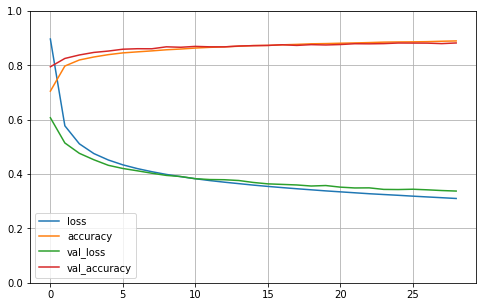

In [9]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
#     纵坐标
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [10]:
model.evaluate(x_test_scaled, y_test, verbose=0)

[0.3722591996192932, 0.8680999875068665]